In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import sweetviz as sv
import xgboost as xgb
import category_encoders as ce
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import FastICA
from sklearn.naive_bayes import GaussianNB
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
heart_dis_pred = pd.read_csv("heart_cleaned_encoded_smote.csv")

In [4]:
predictors = heart_dis_pred.drop("HeartDisease_No",axis=1)
target = heart_dis_pred["HeartDisease_No"]

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

# XGBoost with Scaling + SMOTE

In [5]:
%%time
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, Y_train)



Wall time: 35.7 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [6]:
Y_pred_xgb = xgb_model.predict(X_test)

In [7]:
pkl.dump(xgb_model, open('model_xgb.pkl', 'wb'))

In [8]:
yTest = Y_test.to_frame(name = "HeartDisease_No")
tn, fp, fn, tp = confusion_matrix(yTest, Y_pred_xgb).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  42666 
False positives:  4074 
False negatives:  356 
True Positives:  46480


In [9]:
print(classification_report(yTest, Y_pred_xgb))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     46740
           1       0.92      0.99      0.95     46836

    accuracy                           0.95     93576
   macro avg       0.96      0.95      0.95     93576
weighted avg       0.96      0.95      0.95     93576



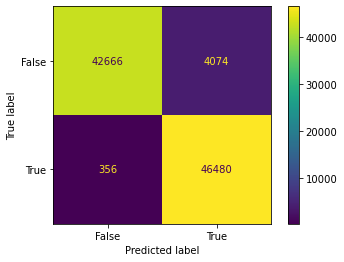

In [10]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(yTest['HeartDisease_No'], Y_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [11]:
test = pd.concat([X_test, Y_test], axis=1)

In [12]:
from deepchecks.checks import RocReport
from deepchecks import Dataset

RocReport().run(Dataset(test, label='HeartDisease_No'), xgb_model)

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\checks.py:21: DeprecationWarning:

Ability to import tabular checks from the `deepchecks.checks` is deprecated, please import from `deepchecks.tabular.checks` instead

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepchecks.tabular` instead

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 1 categorical features were inferred.: Stroke_No


In [15]:
from deepchecks.tabular.suites import full_suite
from deepchecks import Dataset

tempDf = pd.concat([X_train, Y_train], axis=1)
train_ds1 = Dataset(tempDf, label="HeartDisease_No", cat_features=[])
test_ds1 = Dataset(test, label="HeartDisease_No", cat_features=[])
print(tempDf.head(5))
print(test.head(5))

        Unnamed: 0       BMI  PhysicalHealth  MentalHealth  AgeCategory_0  \
311912      311912 -0.516417        3.349118      2.196488      -0.798408   
429482      429482  1.272832       -0.367835     -0.168377      -0.798408   
190026      190026 -0.540489       -0.424070     -0.490039      -0.798408   
62516        62516  2.809054       -0.424070     -0.490039       1.252493   
312548      312548  0.387820       -0.376843     -0.442837      -0.798408   

        AgeCategory_1  AgeCategory_2  AgeCategory_3    Race_0    Race_1  \
311912      -0.899057       0.120623       0.893113 -0.397189 -0.472932   
429482       1.112276      -1.030300      -1.119679 -0.397189 -0.472932   
190026       1.112276       0.970591      -1.119679 -0.397189 -0.472932   
62516       -0.899057      -1.030300      -1.119679 -0.397189 -0.472932   
312548       1.112276       0.970591      -1.119679 -0.397189 -0.472932   

          Race_2  GenHealth_0  GenHealth_1  GenHealth_2  SleepTime  \
311912  0.458684

In [17]:
suite = full_suite()
result = suite.run(train_ds1, test_ds1, xgb_model)
result.save_as_html("Full Suite")

'Full Suite (1).html'

In [26]:
X_resampled = X_train.head(300)
y_resampled = Y_train.head(300)
tempDf = pd.concat([X_resampled, y_resampled], axis=1)
train_ds1 = Dataset(tempDf, label="HeartDisease_No", cat_features=[])
test_ds1 = Dataset(test, label="HeartDisease_No", cat_features=[])

In [27]:
%%time
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_resampled, y_resampled)

Wall time: 81.8 ms


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [28]:
suite = full_suite()
result = suite.run(train_dataset=train_ds1, test_dataset=test_ds1, model=xgb_model)
result.save_as_html("Full_Suite_xgb_1000")

'Full_Suite_xgb_1000 (2).html'

# XGBoost with Scaling + SMOTE + PCA

In [17]:
heart_dis_train_pred = pd.read_csv("heart_cleaned_encoded_trained_pca.csv")
heart_dis_test_pred = pd.read_csv("heart_cleaned_encoded_tested_pca.csv")

In [18]:
%%time
features = ['principal component 1','principal component 2','principal component 3','principal component 4','principal component 5','principal component 6','principal component 7','principal component 8','principal component 9','principal component 10','principal component 11','principal component 12','principal component 13','principal component 14','principal component 15','principal component 16','principal component 17','principal component 18','principal component 19','principal component 20']

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(heart_dis_train_pred[features], heart_dis_train_pred["HeartDisease_No"])

Wall time: 1min 57s


In [ ]:
Y_pred_xgb = xgb_model.predict(heart_dis_test_pred[features])

In [19]:
pkl.dump(xgb_model, open('model_xgb_pca.pkl', 'wb'))

In [21]:
tn, fp, fn, tp = metrics.confusion_matrix(heart_dis_test_pred["HeartDisease_No"], Y_pred_xgb).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  3892 
False positives:  1583 
False negatives:  13430 
True Positives:  45054


In [22]:
print(classification_report(heart_dis_test_pred["HeartDisease_No"], Y_pred_xgb))

              precision    recall  f1-score   support

           0       0.22      0.71      0.34      5475
           1       0.97      0.77      0.86     58484

    accuracy                           0.77     63959
   macro avg       0.60      0.74      0.60     63959
weighted avg       0.90      0.77      0.81     63959



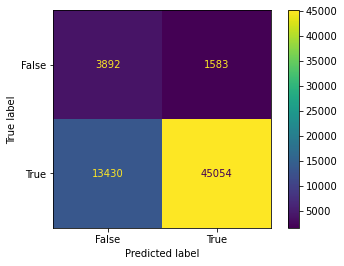

In [28]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(heart_dis_test_pred['HeartDisease_No'], Y_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [27]:
heart_dis_test_pred = heart_dis_test_pred.loc[:, ~heart_dis_test_pred.columns.str.contains('^Unnamed')]
from deepchecks.checks import RocReport
from deepchecks import Dataset
RocReport().run(Dataset(heart_dis_test_pred, label='HeartDisease_No'), xgb_model)

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.


# XGBoost with Scaling + SMOTE + ICA

In [30]:
heart_dis_train_pred = pd.read_csv("heart_cleaned_encoded_trained_ica.csv")
heart_dis_test_pred = pd.read_csv("heart_cleaned_encoded_tested_ica.csv")

In [31]:
%%time
features = ['independent component 1','independent component 2','independent component 3','independent component 4','independent component 5','independent component 6','independent component 7','independent component 8','independent component 9','independent component 10','independent component 11','independent component 12','independent component 13','independent component 14','independent component 15','independent component 16','independent component 17','independent component 18','independent component 19','independent component 20']

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(heart_dis_train_pred[features], heart_dis_train_pred["HeartDisease_No"])

Wall time: 2min 43s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [32]:
Y_pred_xgb = xgb_model.predict(heart_dis_test_pred[features])

In [33]:
pkl.dump(xgb_model, open('model_xgb_ica.pkl', 'wb'))

In [35]:
tn, fp, fn, tp = metrics.confusion_matrix(heart_dis_test_pred["HeartDisease_No"], Y_pred_xgb).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  3561 
False positives:  1914 
False negatives:  11118 
True Positives:  47366


In [36]:
print(classification_report(heart_dis_test_pred["HeartDisease_No"], Y_pred_xgb))

              precision    recall  f1-score   support

           0       0.24      0.65      0.35      5475
           1       0.96      0.81      0.88     58484

    accuracy                           0.80     63959
   macro avg       0.60      0.73      0.62     63959
weighted avg       0.90      0.80      0.83     63959



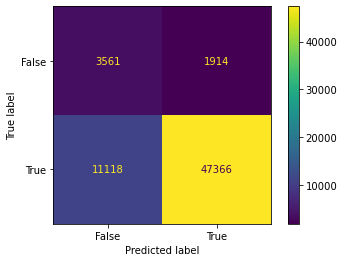

In [37]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(heart_dis_test_pred['HeartDisease_No'], Y_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [38]:
heart_dis_test_pred = heart_dis_test_pred.loc[:, ~heart_dis_test_pred.columns.str.contains('^Unnamed')]
from deepchecks.checks import RocReport
from deepchecks import Dataset
RocReport().run(Dataset(heart_dis_test_pred, label='HeartDisease_No'), xgb_model)

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepchecks.tabular` instead

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.


# XGBoost with Scaling + SMOTE + LDA

In [39]:
heart_dis_train_pred = pd.read_csv("heart_cleaned_encoded_trained_lda.csv")
heart_dis_test_pred = pd.read_csv("heart_cleaned_encoded_tested_lda.csv")

In [40]:
%%time
features = ['lda 1']

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(heart_dis_train_pred[features], heart_dis_train_pred["HeartDisease_No"])

Wall time: 45.2 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [41]:
Y_pred_xgb = xgb_model.predict(heart_dis_test_pred[features])

In [42]:
pkl.dump(xgb_model, open('model_xgb_lda.pkl', 'wb'))

In [43]:
tn, fp, fn, tp = metrics.confusion_matrix(heart_dis_test_pred["HeartDisease_No"], Y_pred_xgb).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  4293 
False positives:  1182 
False negatives:  15751 
True Positives:  42733


In [44]:
print(classification_report(heart_dis_test_pred["HeartDisease_No"], Y_pred_xgb))

              precision    recall  f1-score   support

           0       0.21      0.78      0.34      5475
           1       0.97      0.73      0.83     58484

    accuracy                           0.74     63959
   macro avg       0.59      0.76      0.59     63959
weighted avg       0.91      0.74      0.79     63959



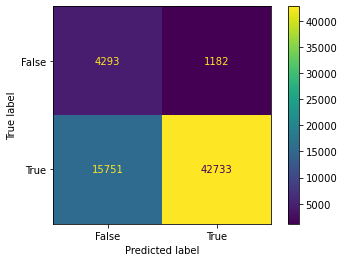

In [45]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(heart_dis_test_pred['HeartDisease_No'], Y_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [46]:
heart_dis_test_pred = heart_dis_test_pred.loc[:, ~heart_dis_test_pred.columns.str.contains('^Unnamed')]
from deepchecks.checks import RocReport
from deepchecks import Dataset
RocReport().run(Dataset(heart_dis_test_pred, label='HeartDisease_No'), xgb_model)

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepchecks.tabular` instead

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.
